In [ ]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta,date
import glob
import matplotlib.pyplot as plt
import datetime
#from py_vollib.black.greeks.analytical import delta
from py_vollib.black.implied_volatility import implied_volatility_of_undiscounted_option_price
from py_vollib.ref_python.black_scholes.implied_volatility import implied_volatility as biv
from py_vollib.ref_python.black_scholes.greeks.analytical import delta

H:\Anaconda\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
H:\Anaconda\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
H:\Anaconda\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


In [ ]:
#classes and function used to store derivatives and calcualate delta of porfolio
def delta_cal(p,f,o):
    exp=datetime.date(2017,1,25)
    total=0
    for n in p:
        if type(n)==future:
            total=total+n.qty
        else:
            if n.typ=="CE":
                typ='c'
            else:
                typ='p'
            cd=datetime.date(o.year,o.month,o.day)
            try:
                v=f[(f["<Strike>"]==n.strike) & (f["<CP>"]==n.typ) & (f["<Ticker>"]==n.naam)]["IV"].values[0]
                dta=f[(f["<Strike>"]==n.strike) & (f["<CP>"]==n.typ) & (f["<Ticker>"]==n.naam)]["Delta"].values[0]
            except:
                v=np.mean(f[(f["<Ticker>"]==n.naam)]["IV"].values)
                dta=delta(typ,combined[n.naam].loc[o],n.strike,((exp-cd).days+1)/365,0.06,v)
            total=total+dta*abs(n.qty)
    return total
class option:
    def __init__(self,price,strike,typ,naam,position,qt):
        self.strike=strike.values[0]
        self.typ=typ
        self.naam=naam
        self.position=position
        self.price=price.values[0]
        self.qty=round(qt)
    def show(self):
        print(self.strike,self.naam,self.typ,self.position,self.qty)
        
class future:
    def __init__(self,price,naam,position,qt):
        self.naam=naam
        self.price=price
        self.position=position
        self.qty=round(qt) 
    def show(self):
        print("futures",self.naam,self.position)
def results(pl,cap):
        p=np.array(pl)
        print("Number of trades",len(pl))
        print("net PnL = "+str(round((p.sum()*100/cap),3))+" %")
        hr=len(np.where(p>0)[0])*100/len(p)
        print(" max loss",p.min()*100/cap)
        rr=np.where(p<0)[0].mean()/np.where(p>0)[0].mean()
        print("Hit ratio :",hr)
        print("Risk to reward ratio :",rr)
        xs = np.array([cap]+pl).cumsum()
        i = np.argmax(np.maximum.accumulate(xs) - xs) # end of the period
        j = np.argmax(xs[:i]) # start of period
        print("Maximum draw down in percent= ",(xs[i]/xs[j]-1)*100)
        plt.plot(xs)
        plt.plot([i, j], [xs[i], xs[j]], 'o', color='Red', markersize=10)
        print("Sharpe ratio",(round((p.sum()/cap),3)-0.005)/(p/cap).std())
        

In [ ]:
import datetime
def ivcal(opti,futi,nam):
    iv=[]
    delt=[]
    for ion in range(0,opti.shape[0]):
        try:
            c=opti.index[ion]
            cd=datetime.date(c.year,c.month,c.day)
            expiry=opti['expiry'][ion]
            exp=datetime.date(expiry.year,expiry.month,expiry.day)
            if opti.iloc[ion]["<CP>"]=="CE":
                typ="c"
            else:
                typ="p"
            test=opti.index[ion]
            sigma=biv(opti['<Close>'].iloc[ion],futi.loc[opti.index[ion]][nam],opti['<Strike>'].iloc[ion],((exp-cd).days+1)/365,0.06,typ)
            delt.append(delta(typ,futi.loc[opti.index[ion]][nam],opti['<Strike>'].iloc[ion],((exp-cd).days+1)/365,0.06,sigma))
            #print(delta(typ,futi.loc[opti.index[ion]][nam],opti['<Strike>'].iloc[ion],((exp-cd).days+1)/365,0.06,sigma))
            iv.append(sigma*100)
        except:
            delt.append(np.nan)
            iv.append(-1)
    opti['IV']=iv
    opti['Delta']=delt
    return opti
    #opti.interpolate(limit=2,inplace=True)

In [ ]:
def otm(price,near):
    put=price-price%near
    call=price-price%near+near
    return (put,call)

In [ ]:
files = glob.glob("F:\EPAT\Final Files\Dispersion Data\options\*.csv")
files
stocks=[]
for i in files:
    stocks.append(pd.read_csv(i))
for i in stocks:
    i.index=pd.to_datetime(i['datetime'],dayfirst=True)
    i['expiry']=pd.to_datetime(i['expiry'])
    i.drop(labels=['datetime'],axis=1)

for i in stocks:
    i.sort_index(inplace=True)

inames=[]
for i in stocks:
    inames.append(i.iloc[0,0])

In [ ]:
files = glob.glob("F:\EPAT\Final Files\Dispersion Data\Data - Options\*.csv")
#xls = pd.ExcelFile('F:\EPAT\Final Files\Dispersion Data\Dispersion-Future Data.xlsx')
futures=[]
#adding futures data as list of dataframes
for i in inames:
    futures.append(pd.read_excel('F:\EPAT\Final Files\Dispersion Data\Dispersion-Future Data.xlsx', sheetname=i)[1:])

H:\Anaconda\lib\site-packages\pandas\util\_decorators.py:188: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  return func(*args, **kwargs)


In [ ]:
stocks[3]

,<Ticker>,<Strike>,<CP>,<Expiry>,<Per-Min>,<Date>,<Time>,<Open>,<High>,<Low>,<Close>,<Volume>,<OI>,datetime,expiry
datetime,,,,,,,,,,,,,,,
2017-01-02 09:15:00,ICICIBANK,285,CE,170125,15,20170102,91500,1.00,1.00,1.00,1.00,10000,40000,02-01-2017 09:15,2017-01-25
2017-01-02 09:15:00,ICICIBANK,255,CE,170125,15,20170102,91500,8.90,8.90,7.75,7.75,50000,407500,02-01-2017 09:15,2017-01-25
2017-01-02 09:15:00,ICICIBANK,260,PE,170125,15,20170102,91500,9.95,11.30,9.95,11.30,80000,332500,02-01-2017 09:15,2017-01-25
2017-01-02 09:15:00,ICICIBANK,260,CE,170125,15,20170102,91500,6.25,6.30,5.65,5.65,200000,1952500,02-01-2017 09:15,2017-01-25
2017-01-02 09:15:00,ICICIBANK,255,PE,170125,15,20170102,91500,7.50,8.55,7.50,8.55,40000,362500,02-01-2017 09:15,2017-01-25
2017-01-02 09:15:00,ICICIBANK,250,PE,170125,15,20170102,91500,5.65,6.20,5.50,6.20,115000,1222500,02-01-2017 09:15,2017-01-25
2017-01-02 09:15:00,ICICIBANK,265,CE,170125,15,20170102,91500,4.45,4.45,4.10,4.20,40000,332500,02-01-2017 09:15,2017-01-25
2017-01-02 09:15:00,ICICIBANK,245,PE,170125,15,20170102,91500,3.85,4.20,3.70,4.20,25000,205000,02-01-2017 09:15,2017-01-25
2017-01-02 09:15:00,ICICIBANK,240,PE,170125,15,20170102,91500,2.75,2.90,2.70,2.90,82500,852500,02-01-2017 09:15,2017-01-25


In [ ]:
for f,names in zip(futures,inames):
    f.index=f.date
    f.columns=['date',names]
    f.drop(labels=['date'],axis=1,inplace=True)

In [ ]:
units=[10,100,20,5,20,10,5,10]
for st,f,u in zip(stocks,futures,units):
    f['units']=u
    st['units']=u

In [ ]:
for i,f,n in zip(stocks,futures,inames):
    print(i.iloc[0,0],f.columns[0],n)

AXISBANK AXISBANK AXISBANK
BANKNIFTY BANKNIFTY BANKNIFTY
HDFCBANK HDFCBANK HDFCBANK
ICICIBANK ICICIBANK ICICIBANK
INDUSINDBK INDUSINDBK INDUSINDBK
KOTAKBANK KOTAKBANK KOTAKBANK
SBIN SBIN SBIN
YESBANK YESBANK YESBANK


In [ ]:
for i,f,names in zip(stocks,futures,inames):
    ivcal(i,f,names)

In [ ]:
for i,s,names in zip(futures,stocks,inames):
    i[names+'vol']=0
    for j in i.index:
        put_strike=otm(i.loc[j][names],i.loc[j]['units'])[0]
        call_strike=otm(i.loc[j][names],i.loc[j]['units'])[1]
        try:
            pe=s.loc[(s['<Strike>']==put_strike) & (s['<CP>']=="PE")  & (s['expiry']==datetime.datetime(2017,1,25))].loc[j]['IV']
            ce=s.loc[(s['<Strike>']==call_strike) & (s['<CP>']=="CE") & (s['expiry']==datetime.datetime(2017,1,25))].loc[j]['IV']
            i[names+"vol"].loc[j]=(pe*(abs(put_strike-i.loc[j][names]))+ce*(abs(call_strike-i.loc[j][names])))/i["units"].loc[j]
        except:
            i[names+"vol"].loc[j]=np.nan

H:\Anaconda\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [ ]:
for i in futures:
    i.fillna(method="ffill",inplace=True)

In [ ]:
futures[1].head()

,BANKNIFTY,units,BANKNIFTYvol
date,,,
2017-01-02 15:15:00,18036.0,100,18.230773
2017-01-02 15:30:00,18031.0,100,18.230773
2017-01-03 09:30:00,17894.4,100,20.679881
2017-01-03 09:45:00,17930.0,100,19.780348
2017-01-03 10:00:00,18048.0,100,18.483578


In [ ]:
#combining the futures prices into one dataframe
combined=pd.DataFrame(index=futures[0].index)
for i,n in zip(futures,inames):
    combined=combined.join(i.drop(labels=["units",n+"vol"],axis=1),on="date")

In [ ]:
x=pd.DataFrame(index=futures[0].index)
for i,n in zip(futures,inames):
    x=x.join(i.drop(labels=[n,"units"],axis=1),on="date")

In [ ]:
index=x["BANKNIFTYvol"]
stks=x.drop(labels=["BANKNIFTYvol"],axis=1)
#stks=x
#these are weights of each stock on BANKNIFTY
#weights=[0.10003877, 0.10448418, 0.19304627, 0.07600258, 0.1208695 ,0.16096953, 0.09721647]
weights=[0.0964,0.3146,0.19,0.0762,0.1123,0.0982,0.0559]

In [ ]:
#constructing the volatility dataframe based on the weights and z values
wx=stks*weights
wx['sum'] = wx.sum(axis=1)
wx['corel'] = index/wx['sum']
wx["index"]=index
wx["z"] = (wx.corel-wx.corel.rolling(30).mean())/wx.corel.rolling(30).std()

In [ ]:
wx.dropna(inplace=True)

In [ ]:
wx.head()

,AXISBANKvol,HDFCBANKvol,ICICIBANKvol,INDUSINDBKvol,KOTAKBANKvol,SBINvol,YESBANKvol,sum,corel,index,z
date,,,,,,,,,,,
2017-01-04 10:00:00,3.461094,3.074662,5.537436,1.929014,2.634181,2.947527,1.818056,21.401972,0.912373,19.526575,2.064488
2017-01-04 10:15:00,3.410335,3.074662,5.496306,1.844598,2.727127,2.940130,1.818056,21.311214,0.919561,19.596957,1.993267
2017-01-04 10:30:00,3.423403,3.074662,5.397791,1.893636,2.491493,2.879347,1.818056,20.978388,0.899999,18.880529,1.660944
2017-01-04 10:45:00,3.282427,3.074662,6.439914,2.201891,2.538907,3.235229,1.818056,22.591087,0.777185,17.557446,0.251110
2017-01-04 11:00:00,3.306443,7.647011,5.948399,2.198794,2.491140,2.866051,1.818056,26.275893,0.667228,17.532017,-0.977232


In [ ]:
#combing the data of options into one dataframe
temp=stocks
for i in temp[1:]:
    temp[0]=temp[0].append(i)

In [ ]:
#weights of the stocks in banknifty where 1 represents the BANKNIFTY itself.This list below is to support the backtest
cont=[0.0964,1,0.3146,0.19,0.0762,0.1123,0.0982,0.0559]

In [ ]:
#The backtest is for 100 qty or 4 lots of BANKNIFTY  - 100 qty on CE and 100 qty on PE
size=100

In [ ]:
port=[]
futures_port=[]
pnl=[]
trades=0
dates=[]
count=0
pos=""
for i in wx.index:
    print(i)
    try:
        frame=temp[0].loc[i]
    except:
        print("datetime on options not available so skipping to next")
        continue
    count=count+1
    bnf=combined["BANKNIFTY"].loc[i]
    if wx.z.loc[i]>1 and pos=="":
        print("taking short since Z=",wx.z.loc[i])
        frame=temp[0].loc[i]
        frame=frame[frame["<Expiry>"]==170125]
        for j,u,q in zip(inames,units,cont):
            if j =="BANKNIFTY" or u==100:
                continue
            strikes=otm(combined[j].loc[i],u)
            put=frame[(frame["<Strike>"]==strikes[0]) & (frame["<CP>"]=="PE") & (frame["<Ticker>"]==j)]
            new_strike=strikes[0]
            while put.empty:
                new_strike = new_strike-u
                put = frame[(frame["<Strike>"]==new_strike) & (frame["<CP>"]=="PE") & (frame["<Ticker>"]==j)]
            call=frame[(frame["<Strike>"]==strikes[1]) & (frame["<CP>"]=="CE") & (frame["<Ticker>"]==j)]
            new_strike=strikes[1]
            while call.empty:
                new_strike = new_strike+u
                call = frame[(frame["<Strike>"]==new_strike) & (frame["<CP>"]=="CE") & (frame["<Ticker>"]==j)]
            port.append(option(put["<Close>"],put["<Strike>"],"PE",j,"buy",size*bnf*q/combined[j].loc[i]))
            port.append(option(call["<Close>"],call["<Strike>"],"CE",j,"buy",size*bnf*q/combined[j].loc[i]))
            #capital=capital+put["<Strike>"].values[0]*size*bnf*q/combined[j].loc[i]+call["<Strike>"].values[0]*size*bnf*q/combined[j].loc[i]
            print("Buying",call["<Strike>"].values[0],"calls of",j,"at",call["<Close>"].values[0],"qty=",size*bnf*q/combined[j].loc[i])
            print("Buying",put["<Strike>"].values[0],"puts of",j,"at",put["<Close>"].values[0],"qty=",size*bnf*q/combined[j].loc[i])
        strikes=otm(combined["BANKNIFTY"].loc[i],100)   
        put=frame[(frame["<Strike>"]==strikes[0]) & (frame["<CP>"]=="PE") & (frame["<Ticker>"]=="BANKNIFTY")]
        call=frame[(frame["<Strike>"]==strikes[1]) & (frame["<CP>"]=="CE") & (frame["<Ticker>"]=="BANKNIFTY")]
        port.append(option(put["<Close>"],put["<Strike>"],"PE","BANKNIFTY","sell",size))
        port.append(option(call["<Close>"],call["<Strike>"],"CE","BANKNIFTY","sell",size))
        print("selling",call["<Strike>"].values[0],"calls of","BANKNIFTY","at",call["<Close>"].values[0],"qty=",size)
        print("selling",put["<Strike>"].values[0],"puts of","BANKNIFTY","at",put["<Close>"].values[0],"qty=",size)
        print("...........................................................................................................")
        pos="short"
    if abs(wx.z.loc[i])<0.8 and pos!="":
        trades=trades+1
        temp_pnl=0
        print("square off")
        pos=""
        frame=temp[0].loc[i]
        frame=frame[frame["<Expiry>"]==170125]
        for k in port:
            try:
                if k.position=="buy" and type(k)==option:
                    f1 = frame[(frame["<Strike>"]==k.strike) & (frame["<CP>"]==k.typ) & (frame["<Ticker>"]==k.naam)]["<Close>"]
                    pnl.append((f1.values[0]-k.price)*k.qty)
                    dates.append(date(year=i.year,month=i.month,day=i.day))
                    temp_pnl=temp_pnl+(f1.values[0]-k.price)*k.qty
                    print("squaring off",k.show(),"between",k.price,"and",f1.values[0])
            except:
                try:
                    if k.typ=="CE":
                        un=frame[(frame["<Ticker>"]==k.naam)]["units"].values[0]
                        f1 = frame[(frame["<Strike>"]==k.strike+un) & (frame["<CP>"]==k.typ) & (frame["<Ticker>"]==k.naam)]["<Close>"]
                        pnl.append((f1.values[0]-k.price)*k.qty)
                        dates.append(date(year=i.year,month=i.month,day=i.day))
                        temp_pnl=temp_pnl+(f1.values[0]-k.price)*k.qty
                        print("squaring off",k.show(),"between",k.price,"and",f1.values[0])
                    else:
                        un=frame[(frame["<Ticker>"]==k.naam)]["units"].values[0]
                        f1 = frame[(frame["<Strike>"]==k.strike-un) & (frame["<CP>"]==k.typ) & (frame["<Ticker>"]==k.naam)]["<Close>"]
                        pnl.append((f1.values[0]-k.price)*k.qty)
                        dates.append(date(year=i.year,month=i.month,day=i.day))
                        temp_pnl=temp_pnl+(f1.values[0]-k.price)*k.qty
                        print("squaring off",k.show(),"between",k.price,"and",f1.values[0])
                        
                except:
                    pass
            try:
                if k.position=="sell" and type(k)==option:
                    f1 = frame[(frame["<Strike>"]==k.strike) & (frame["<CP>"]==k.typ) & (frame["<Ticker>"]==k.naam)]["<Close>"]
                    test=i
                    pnl.append((k.price-f1.values[0])*k.qty)
                    dates.append(date(year=i.year,month=i.month,day=i.day))
                    temp_pnl=temp_pnl+(k.price-f1.values[0])*k.qty
                    print("squaring off",k.show(),"between",k.price,"and",f1.values[0])
            except:
                try:
                    un=frame[(frame["<Ticker>"]==k.naam)]["units"].values[0]
                    #print(k.naam,f1,k.strike,k.typ)
                    if k.typ=="PE":
                        f1 = frame[(frame["<Strike>"]==k.strike-un) & (frame["<CP>"]=="PE") & (frame["<Ticker>"]==k.naam)]["<Close>"]
                        if k.position=="sell" and type(k)==option:
                            pnl.append((k.price-f1.values[0])*k.qty)
                            dates.append(date(year=i.year,month=i.month,day=i.day))
                            temp_pnl=temp_pnl+(k.price-f1.values[0])*k.qty
                            print("squaring off",k.show(),"between",k.price,"and",f1.values[0])
                    else:
                        f1 = frame[(frame["<Strike>"]==k.strike+un) & (frame["<CP>"]==k.typ) & (frame["<Ticker>"]==k.naam)]["<Close>"]
                        if k.position=="sell" and type(k)==option:
                            pnl.append((k.price-f1.values[0])*k.qty)
                            dates.append(date(year=i.year,month=i.month,day=i.day))
                            temp_pnl=temp_pnl+(k.price-f1.values[0])*k.qty
                            print("squaring off",k.show(),"between",k.price,"and",f1.values[0])
                except:
                    pass
            if k.position=="sell" and type(k)==future:
                f1 = combined[k.naam].loc[i]
                pnl.append((k.price-f1)*k.qty)
                dates.append(date(year=i.year,month=i.month,day=i.day))
                temp_pnl=temp_pnl+(k.price-f1)*k.qty
                print("squaring off",k.show(),"between",k.price,"and",f1)
            if k.position=="buy" and type(k)==future:
                f1 = combined[k.naam].loc[i]
                pnl.append((f1-k.price)*k.qty)
                dates.append(date(year=i.year,month=i.month,day=i.day))
                temp_pnl=temp_pnl+(f1-k.price)*k.qty
                print("squaring off",k.show(),"between",k.price,"and",f1)
        port=[]
        print("................................Squared off.............with ",temp_pnl,"......................................")
        if i.day==25:
            break
    if wx.z.loc[i]<-1 and pos=="":
        print("long",wx.z.loc[i])
        frame=temp[0].loc[i]
        frame=frame[frame["<Expiry>"]==170125]
        for j,u,q in zip(inames,units,cont):
            if j =="BANKNIFTY" or u==100:
                continue
            strikes=otm(combined[j].loc[i],u)
            put=frame[(frame["<Strike>"]==strikes[0]) & (frame["<CP>"]=="PE") & (frame["<Ticker>"]==j)]
            new_strike=strikes[0]
            while put.empty:
                new_strike = new_strike-u
                put = frame[(frame["<Strike>"]==new_strike) & (frame["<CP>"]=="PE") & (frame["<Ticker>"]==j)]
            call=frame[(frame["<Strike>"]==strikes[1]) & (frame["<CP>"]=="CE") & (frame["<Ticker>"]==j)]
            new_strike=strikes[1]
            while call.empty:
                new_strike=new_strike+u
                print("empty call")
                call = frame[(frame["<Strike>"]==new_strike) & (frame["<CP>"]=="CE") & (frame["<Ticker>"]==j)]
            port.append(option(put["<Close>"],put["<Strike>"],"PE",j,"sell",size*bnf*q/combined[j].loc[i]))
            port.append(option(call["<Close>"],call["<Strike>"],"CE",j,"sell",size*bnf*q/combined[j].loc[i]))
            #capital=capital
            print("selling",call["<Strike>"].values[0],"calls of",j,"at",call["<Close>"].values[0],"qty=",size*bnf*q/combined[j].loc[i])
            print("selling",put["<Strike>"].values[0],"puts of",j,"at",put["<Close>"].values[0],"qty=",size*bnf*q/combined[j].loc[i])
        strikes=otm(combined["BANKNIFTY"].loc[i],100)   
        put=frame[(frame["<Strike>"]==strikes[0]) & (frame["<CP>"]=="PE") & (frame["<Ticker>"]=="BANKNIFTY")]
        call=frame[(frame["<Strike>"]==strikes[1]) & (frame["<CP>"]=="CE") & (frame["<Ticker>"]=="BANKNIFTY")]
        port.append(option(put["<Close>"],put["<Strike>"],"PE","BANKNIFTY","buy",size))
        port.append(option(call["<Close>"],call["<Strike>"],"CE","BANKNIFTY","buy",size))
        #capital=capital+put["<Strike>"].values[0]*size*bnf*q/combined[j].loc[i]+call["<Strike>"].values[0]*size*bnf*q/combined[j].loc[i]
        print("buying",call["<Strike>"].values[0],"calls of","BANKNIFTY","at",call["<Close>"].values[0],"qty=",size)
        print("buying",put["<Strike>"].values[0],"puts of","BANKNIFTY","at",put["<Close>"].values[0],"qty=",size)
        print(".........................................................................................................")
        pos="long"

    if abs(wx.z.loc[i])>=0.8 and pos!="":
        frame=temp[0].loc[i]
        frame=frame[frame["<Expiry>"]==170125]
        print("***************************hedging if absolute value of delta per quantity is greater than 0.1***************************")
        for m in inames:
            temp_port=[]
            for l in port:
                if m!=l.naam:
                    continue
                temp_port.append(l)
            #cmp=frame[(frame["<Strike>"]==l.strike.values[0]) & (frame["<CP>"]==l.typ) & (frame["<Ticker>"]==l.naam)]['<Close>']
            port_delta=delta_cal(temp_port,frame,i)
            total_qty=0
            for t in temp_port:
                total_qty=total_qty+t.qty
            future_found=0
            if port_delta/total_qty>0.1:
                print("delta of",m,"= ",port_delta/total_qty,">0.1")
                for r in temp_port:
                    if type(r)==future:
                        future_found=1
                        pqty=r.qty
                        pprice=r.price
                        if r.qty>0:
                            if abs(r.qty)>abs(port_delta):
                                pnl.append((combined[r.naam].loc[i]-r.price)*(min(r.qty,round(port_delta))))
                                dates.append(date(year=i.year,month=i.month,day=i.day))
                                r.qty=r.qty-round(port_delta)
                                #r.price=combined[r.naam].loc[i]
                                print("existing qty >0 so qty changes:",pqty,"to",r.qty,"price changes from",pprice,"to",r.price)
                            else:
                                pnl.append((combined[r.naam].loc[i]-r.price)*(min(r.qty,round(port_delta))))
                                dates.append(date(year=i.year,month=i.month,day=i.day))
                                r.qty=r.qty-round(port_delta)
                                r.price=combined[r.naam].loc[i]
                                print("existing qty >0 so qty changes:",pqty,"to",r.qty,"price changes from",pprice,"to",r.price)
                        elif r.qty<0:
                            r.price = (abs(r.price*r.qty)+combined[r.naam].loc[i]*round(port_delta))/(abs(r.qty)+round(port_delta))
                            r.qty=r.qty-round(port_delta)
                            print("existing qty <0 so qty changes:",pqty,"to",r.qty,"price changes from",pprice,"to",r.price)
                        else:
                            pass
                if future_found!=1:
                    print("new futures,of ",m,"is sold at",combined[r.naam].loc[i],"and qty=",-1*round(port_delta))
                    port.append(future(combined[r.naam].loc[i],m,"sell",-1*round(port_delta)))
            future_found=0
            if port_delta/total_qty<-0.1:
                print("delta of",m," = ",port_delta/total_qty,"<-0.1")
                for r in temp_port:
                    if type(r)==future:
                        pprice=r.price
                        pqty=r.qty
                        future_found=1
                        if r.qty<0:
                            if abs(r.qty)>abs(port_delta):
                                pnl.append((r.price-combined[r.naam].loc[i])*(min(abs(r.qty),abs(round(port_delta)))))
                                dates.append(date(year=i.year,month=i.month,day=i.day))
                                r.qty=r.qty-round(port_delta)
                                #r.price=(combined[r.naam].loc[i]*r.qty+abs(combined[r.naam].loc[i]*round(port_delta)))/(r.qty+abs(round(port_delta)))
                                print("existing qty < 0 so qty changes:",pqty,"to",r.qty,"price changes from",pprice,"to",r.price)
                            else:
                                pnl.append((r.price-combined[r.naam].loc[i])*(min(abs(r.qty),abs(round(port_delta)))))
                                dates.append(date(year=i.year,month=i.month,day=i.day))
                                r.qty=r.qty-round(port_delta)
                                r.price=combined[r.naam].loc[i]
                                print("existing qty < 0 so qty changes:",pqty,"to",r.qty,"price changes from",pprice,"to",r.price) 
                        elif r.qty>0:
                            r.price = (r.price*r.qty+abs(combined[r.naam].loc[i]*round(port_delta)))/(r.qty+abs(round(port_delta)))
                            r.qty=r.qty-round(port_delta)
                            print("existing qty > 0 so qty changes:",pqty,"to",r.qty,"price changes from",pprice,"to",r.price)
                        else:
                            pass
                if future_found!=1:
                    port.append(future(combined[r.naam].loc[i],m,"buy",-1*round(port_delta)))
                    print("new futures,of ",m,"is bought at",combined[r.naam].loc[i],"and qty=",-1*round(port_delta))
        for m in inames:
            temp_port=[]
            for l in port:
                if m!=l.naam:
                    continue
                temp_port.append(l)
            #cmp=frame[(frame["<Strike>"]==l.strike.values[0]) & (frame["<CP>"]==l.typ) & (frame["<Ticker>"]==l.naam)]['<Close>']
            total_qty=0
            for t in temp_port:
                total_qty=total_qty+t.qty
            port_delta=delta_cal(temp_port,frame,i)
            print("Delta of",m,port_delta/total_qty)
        print("**************Hedge done***********")

2017-01-04 10:00:00
taking short since Z= 2.064487532150762
Buying 460 calls of AXISBANK at 14.0 qty= 380.32736842105265
Buying 450 puts of AXISBANK at 12.1 qty= 380.32736842105265
Buying 1240 calls of HDFCBANK at 4.55 qty= 463.3098581560283
Buying 1200 puts of HDFCBANK at 25.0 qty= 463.3098581560283
Buying 260 calls of ICICIBANK at 5.55 qty= 1344.478848413631
Buying 255 puts of ICICIBANK at 7.65 qty= 1344.478848413631
Buying 1120 calls of INDUSINDBK at 20.7 qty= 124.70286348401123
Buying 1100 puts of INDUSINDBK at 28.5 qty= 124.70286348401123
Buying 710 calls of KOTAKBANK at 14.0 qty= 286.52796624532164
Buying 700 puts of KOTAKBANK at 12.0 qty= 286.52796624532164
Buying 250 calls of SBIN at 5.55 qty= 722.3277728013029
Buying 245 puts of SBIN at 7.25 qty= 722.3277728013029
Buying 1180 calls of YESBANK at 29.35 qty= 86.2026670934699
Buying 1160 puts of YESBANK at 30.5 qty= 86.2026670934699
selling 18100 calls of BANKNIFTY at 311.0 qty= 100
selling 18000 puts of BANKNIFTY at 308.75 qty= 

delta of INDUSINDBK =  0.16513087022080608 >0.1
new futures,of  INDUSINDBK is sold at 1099.0 and qty= -41
Delta of AXISBANK 0.03264358651111634
Delta of BANKNIFTY 0.015554756275488586
Delta of HDFCBANK 0.05584173815979772
Delta of ICICIBANK 0.040257416480504515
Delta of INDUSINDBK 0.0013527155751268994
Delta of KOTAKBANK 0.009180072338333808
Delta of SBIN 0.0655871202490494
Delta of YESBANK 0.02055196257485218
**************Hedge done***********
2017-01-04 13:00:00
***************************hedging if absolute value of delta per quantity is greater than 0.1***************************
delta of HDFCBANK =  0.22915387461679512 >0.1
new futures,of  HDFCBANK is sold at 1214.65 and qty= -214
delta of INDUSINDBK =  0.11998673636083654 >0.1
existing qty <0 so qty changes: -41 to -66 price changes from 1099.0 to 1098.9621212121212
Delta of AXISBANK 0.041857565615894564
Delta of BANKNIFTY 0.015670595449302275
Delta of HDFCBANK -0.0005969204138536689
Delta of ICICIBANK 0.04264650690100973
Delta 

Buying 250 calls of SBIN at 4.9 qty= 725.3255172413793
Buying 245 puts of SBIN at 6.3 qty= 725.3255172413793
Buying 1200 calls of YESBANK at 29.3 qty= 84.83142533746961
Buying 1180 puts of YESBANK at 25.35 qty= 84.83142533746961
selling 18100 calls of BANKNIFTY at 327.3 qty= 100
selling 18000 puts of BANKNIFTY at 260.55 qty= 100
...........................................................................................................
***************************hedging if absolute value of delta per quantity is greater than 0.1***************************
Delta of AXISBANK 0.06843936129755868
Delta of BANKNIFTY 0.06358294333912148
Delta of HDFCBANK -0.08890813564457238
Delta of ICICIBANK -0.0014348591394222699
Delta of INDUSINDBK 0.08896913990851917
Delta of KOTAKBANK 0.005123886801650292
Delta of SBIN -0.02365498138627286
Delta of YESBANK 0.04519080224097716
**************Hedge done***********
2017-01-05 12:00:00
***************************hedging if absolute value of delta per quantit

***************************hedging if absolute value of delta per quantity is greater than 0.1***************************
delta of HDFCBANK =  0.10172971647866066 >0.1
new futures,of  HDFCBANK is sold at 1219.05 and qty= -95
Delta of AXISBANK -0.006242987911325149
Delta of BANKNIFTY 0.0259853262088766
Delta of HDFCBANK 0.0002604216694725157
Delta of ICICIBANK 0.016542521266351678
Delta of INDUSINDBK 0.04541913749831929
Delta of KOTAKBANK -0.00791813674557406
Delta of SBIN -0.01445739601286936
Delta of YESBANK 0.04390591526989985
**************Hedge done***********
2017-01-05 14:45:00
square off
460 AXISBANK PE sell 378
squaring off None between 14.2 and 14.65
470 AXISBANK CE sell 378
squaring off None between 10.35 and 10.0
1200 HDFCBANK PE sell 468
squaring off None between 25.25 and 24.8
1220 HDFCBANK CE sell 468
squaring off None between 7.85 and 7.55
255 ICICIBANK PE sell 1341
squaring off None between 5.45 and 5.35
260 ICICIBANK CE sell 1341
squaring off None between 5.85 and 5.9


450 AXISBANK PE sell 386
squaring off None between 11.15 and 10.2
460 AXISBANK CE sell 386
squaring off None between 13.7 and 14.85
1200 HDFCBANK PE sell 468
squaring off None between 19.05 and 19.2
1240 HDFCBANK CE sell 468
squaring off None between 4.25 and 4.25
255 ICICIBANK PE sell 1342
squaring off None between 4.8 and 4.6
260 ICICIBANK CE sell 1342
squaring off None between 6.0 and 6.15
1100 INDUSINDBK PE sell 121
squaring off None between 9.85 and 9.5
1160 INDUSINDBK CE sell 121
squaring off None between 21.85 and 23.0
700 KOTAKBANK PE sell 289
squaring off None between 10.0 and 10.3
720 KOTAKBANK CE sell 289
squaring off None between 9.65 and 9.9
245 SBIN PE sell 726
squaring off None between 5.2 and 5.05
250 SBIN CE sell 726
squaring off None between 5.45 and 5.55
1240 YESBANK PE sell 82
squaring off None between 31.8 and 30.45
1250 YESBANK CE sell 82
squaring off None between 28.75 and 29.0
18300 BANKNIFTY PE buy 100
squaring off None between 286.0 and 283.0
18400 BANKNIFTY C

1280 YESBANK CE buy 81
squaring off None between 23.5 and 21.0
18300 BANKNIFTY PE sell 100
squaring off None between 249.0 and 241.0
18400 BANKNIFTY CE sell 100
squaring off None between 243.25 and 242.3
................................Squared off.............with  543.3499999999992 ......................................
2017-01-09 10:30:00
2017-01-09 10:45:00
2017-01-09 11:00:00
2017-01-09 11:15:00
2017-01-09 11:30:00
2017-01-09 11:45:00
2017-01-09 12:00:00
2017-01-09 12:15:00
2017-01-09 12:30:00
2017-01-09 12:45:00
2017-01-09 13:00:00
2017-01-09 13:15:00
2017-01-09 13:30:00
2017-01-09 13:45:00
2017-01-09 14:00:00
2017-01-09 14:15:00
2017-01-09 14:30:00
2017-01-09 14:45:00
2017-01-09 15:00:00
2017-01-09 15:15:00
taking short since Z= 1.0089308007849285
Buying 460 calls of AXISBANK at 12.2 qty= 389.12243011226064
Buying 450 puts of AXISBANK at 12.1 qty= 389.12243011226064
Buying 1240 calls of HDFCBANK at 4.15 qty= 470.4697084607543
Buying 1220 puts of HDFCBANK at 28.0 qty= 470.46970846

squaring off None between 12.2 and 10.0
1220 HDFCBANK PE buy 470
squaring off None between 28.0 and 19.0
1240 HDFCBANK CE buy 470
squaring off None between 4.15 and 6.35
255 ICICIBANK PE buy 1347
squaring off None between 4.3 and 4.3
260 ICICIBANK CE buy 1347
squaring off None between 5.7 and 5.35
1160 INDUSINDBK PE buy 120
squaring off None between 27.65 and 30.65
1180 INDUSINDBK CE buy 120
squaring off None between 18.3 and 13.4
710 KOTAKBANK PE buy 290
squaring off None between 14.5 and 12.05
720 KOTAKBANK CE buy 290
squaring off None between 10.45 and 11.2
245 SBIN PE buy 727
squaring off None between 4.6 and 4.9
250 SBIN CE buy 727
squaring off None between 4.85 and 4.45
1250 YESBANK PE buy 81
squaring off None between 29.15 and 27.45
1260 YESBANK CE buy 81
squaring off None between 31.65 and 31.8
18300 BANKNIFTY PE sell 100
squaring off None between 261.0 and 226.95
18400 BANKNIFTY CE sell 100
squaring off None between 229.4 and 234.0
futures ICICIBANK sell
squaring off None betw

selling 260 calls of ICICIBANK at 6.5 qty= 1347.19291490181
selling 255 puts of ICICIBANK at 3.7 qty= 1347.19291490181
selling 1180 calls of INDUSINDBK at 18.0 qty= 119.68157625383826
selling 1160 puts of INDUSINDBK at 17.8 qty= 119.68157625383826
selling 720 calls of KOTAKBANK at 10.5 qty= 290.2101185881693
selling 710 puts of KOTAKBANK at 11.55 qty= 290.2101185881693
selling 250 calls of SBIN at 5.4 qty= 728.9880266075387
selling 245 puts of SBIN at 3.95 qty= 728.9880266075387
empty call
selling 1280 calls of YESBANK at 26.8 qty= 81.34202062507407
selling 1260 puts of YESBANK at 26.05 qty= 81.34202062507407
buying 18500 calls of BANKNIFTY at 215.5 qty= 100
buying 18400 puts of BANKNIFTY at 217.0 qty= 100
.........................................................................................................
***************************hedging if absolute value of delta per quantity is greater than 0.1***************************
delta of HDFCBANK =  0.10198561909338309 >0.1
new future

selling 1220 calls of INDUSINDBK at 19.85 qty= 117.29912171052631
selling 1200 puts of INDUSINDBK at 15.75 qty= 117.29912171052631
selling 730 calls of KOTAKBANK at 10.75 qty= 290.8271693414499
selling 720 puts of KOTAKBANK at 12.5 qty= 290.8271693414499
selling 255 calls of SBIN at 3.95 qty= 731.4630003979306
selling 250 puts of SBIN at 5.05 qty= 731.4630003979306
empty call
selling 1320 calls of YESBANK at 25.8 qty= 80.1048604784689
selling 1300 puts of YESBANK at 29.1 qty= 80.1048604784689
buying 18800 calls of BANKNIFTY at 179.25 qty= 100
buying 18700 puts of BANKNIFTY at 232.8 qty= 100
.........................................................................................................
***************************hedging if absolute value of delta per quantity is greater than 0.1***************************
Delta of AXISBANK 0.0013948703858709774
Delta of BANKNIFTY 0.011373405919135103
Delta of HDFCBANK 0.016470889437997963
Delta of ICICIBANK 0.041945137366276745
Delta of INDUSI

squaring off None between 192.15 and 210.1
................................Squared off.............with  550.3499999999976 ......................................
2017-01-11 14:00:00
2017-01-11 14:15:00
2017-01-11 14:30:00
2017-01-11 14:45:00
2017-01-11 15:00:00
taking short since Z= 2.2020045305272227
Buying 460 calls of AXISBANK at 11.6 qty= 399.77945969690313
Buying 450 puts of AXISBANK at 12.25 qty= 399.77945969690313
Buying 1240 calls of HDFCBANK at 12.7 qty= 482.1381291343696
Buying 1220 puts of HDFCBANK at 9.4 qty= 482.1381291343696
Buying 270 calls of ICICIBANK at 3.8 qty= 1347.9327446928426
Buying 265 puts of ICICIBANK at 5.5 qty= 1347.9327446928426
Buying 1240 calls of INDUSINDBK at 17.0 qty= 116.91740126767432
Buying 1220 puts of INDUSINDBK at 17.4 qty= 116.91740126767432
Buying 740 calls of KOTAKBANK at 7.25 qty= 289.9514440038288
Buying 730 puts of KOTAKBANK at 13.1 qty= 289.9514440038288
Buying 255 calls of SBIN at 4.5 qty= 731.144692429022
Buying 250 puts of SBIN at 4.25 

squaring off None between 3.7 and 3.85
255 SBIN CE buy 732
squaring off None between 4.6 and 4.4
1320 YESBANK PE buy 80
squaring off None between 29.8 and 32.0
1340 YESBANK CE buy 80
squaring off None between 25.85 and 23.75
18800 BANKNIFTY PE sell 100
squaring off None between 183.75 and 188.0
18900 BANKNIFTY CE sell 100
squaring off None between 205.8 and 199.85
................................Squared off.............with  318.200000000004 ......................................
2017-01-12 12:00:00
2017-01-12 12:15:00
2017-01-12 12:30:00
2017-01-12 12:45:00
2017-01-12 13:00:00
long -1.9608935084394532
selling 460 calls of AXISBANK at 12.7 qty= 399.23722763604513
selling 450 puts of AXISBANK at 10.4 qty= 399.23722763604513
selling 1240 calls of HDFCBANK at 14.85 qty= 484.50449511400655
selling 1220 puts of HDFCBANK at 7.85 qty= 484.50449511400655
selling 270 calls of ICICIBANK at 4.95 qty= 1339.2769288110323
selling 265 puts of ICICIBANK at 4.3 qty= 1339.2769288110323
selling 1240 call

Delta of HDFCBANK -0.00045005941012147806
Delta of ICICIBANK -0.020997327123675354
Delta of INDUSINDBK -0.048118235027662215
Delta of KOTAKBANK 0.009488269226279853
Delta of SBIN 0.09768551617611576
Delta of YESBANK 0.03877170451781078
**************Hedge done***********
2017-01-13 10:30:00
square off
450 AXISBANK PE sell 395
squaring off None between 9.15 and 7.8
460 AXISBANK CE sell 395
squaring off None between 13.2 and 14.3
1220 HDFCBANK PE sell 478
squaring off None between 8.45 and 8.65
1240 HDFCBANK CE sell 478
squaring off None between 11.65 and 11.5
265 ICICIBANK PE sell 1345
squaring off None between 4.5 and 4.15
270 ICICIBANK CE sell 1345
squaring off None between 3.35 and 3.7
1220 INDUSINDBK PE sell 118
squaring off None between 20.5 and 19.6
1240 INDUSINDBK CE sell 118
squaring off None between 12.5 and 13.05
730 KOTAKBANK PE sell 288
squaring off None between 10.2 and 10.4
740 KOTAKBANK CE sell 288
squaring off None between 8.45 and 8.1
245 SBIN PE sell 741
squaring off N

Delta of AXISBANK 0.00030797555400835513
Delta of BANKNIFTY 0.001238472777096149
Delta of HDFCBANK -0.028299390576907828
Delta of ICICIBANK 0.014264027396921982
Delta of INDUSINDBK 0.05195594121313893
Delta of KOTAKBANK -0.00261183785048901
Delta of SBIN 0.0005388078215101138
Delta of YESBANK -0.03166185909975794
**************Hedge done***********
2017-01-13 13:15:00
***************************hedging if absolute value of delta per quantity is greater than 0.1***************************
delta of HDFCBANK =  0.1085494895829157 >0.1
new futures,of  HDFCBANK is sold at 1250.15 and qty= -104
delta of KOTAKBANK =  0.22536056738342036 >0.1
existing qty >0 so qty changes: 39 to -100 price changes from 728.15 to 728.0
Delta of AXISBANK 0.009884809396261709
Delta of BANKNIFTY 0.010389450409622327
Delta of HDFCBANK -0.0005221022798804979
Delta of ICICIBANK 0.03495457513122017
Delta of INDUSINDBK 0.016439098926549215
Delta of KOTAKBANK 0.00103789835486916
Delta of SBIN 0.006259805096393542
Delta

selling 1260 calls of HDFCBANK at 6.9 qty= 475.74448578811365
selling 1220 puts of HDFCBANK at 4.95 qty= 475.74448578811365
selling 270 calls of ICICIBANK at 3.55 qty= 1350.444880418535
selling 265 puts of ICICIBANK at 3.35 qty= 1350.444880418535
selling 1240 calls of INDUSINDBK at 10.35 qty= 118.6217212309707
selling 1220 puts of INDUSINDBK at 16.4 qty= 118.6217212309707
selling 730 calls of KOTAKBANK at 10.85 qty= 293.4185569063809
selling 720 puts of KOTAKBANK at 6.9 qty= 293.4185569063809
selling 255 calls of SBIN at 3.8 qty= 737.3703474141333
selling 250 puts of SBIN at 2.85 qty= 737.3703474141333
empty call
selling 1340 calls of YESBANK at 24.7 qty= 79.98308921989018
selling 1320 puts of YESBANK at 23.9 qty= 79.98308921989018
buying 19100 calls of BANKNIFTY at 149.0 qty= 100
buying 19000 puts of BANKNIFTY at 177.0 qty= 100
.........................................................................................................
***************************hedging if absolute value 

470 AXISBANK PE buy 384
squaring off None between 8.25 and 8.2
480 AXISBANK CE buy 384
squaring off None between 12.05 and 12.35
1260 HDFCBANK PE buy 476
squaring off None between 19.85 and 8.85
1280 HDFCBANK CE buy 476
squaring off None between 4.2 and 3.8
270 ICICIBANK PE buy 1340
squaring off None between 4.2 and 4.25
275 ICICIBANK CE buy 1340
squaring off None between 3.1 and 2.95
1220 INDUSINDBK PE buy 119
squaring off None between 16.35 and 14.4
1240 INDUSINDBK CE buy 119
squaring off None between 9.75 and 11.0
720 KOTAKBANK PE buy 294
squaring off None between 5.95 and 5.05
730 KOTAKBANK CE buy 294
squaring off None between 12.5 and 12.95
250 SBIN PE buy 737
squaring off None between 2.35 and 2.25
255 SBIN CE buy 737
squaring off None between 4.35 and 4.25
1320 YESBANK PE buy 80
squaring off None between 19.65 and 21.6
1340 YESBANK CE buy 80
squaring off None between 27.05 and 25.1
19100 BANKNIFTY PE sell 100
squaring off None between 166.0 and 169.0
19200 BANKNIFTY CE sell 100


Buying 1200 puts of INDUSINDBK at 7.95 qty= 119.3328241082411
Buying 730 calls of KOTAKBANK at 10.35 qty= 294.6016188186813
Buying 720 puts of KOTAKBANK at 6.6 qty= 294.6016188186813
Buying 260 calls of SBIN at 2.75 qty= 730.8724434918161
Buying 255 puts of SBIN at 3.1 qty= 730.8724434918161
Buying 1340 calls of YESBANK at 22.0 qty= 80.48972028499266
Buying 1320 puts of YESBANK at 24.0 qty= 80.48972028499266
selling 19100 calls of BANKNIFTY at 190.35 qty= 100
selling 19000 puts of BANKNIFTY at 140.0 qty= 100
...........................................................................................................
***************************hedging if absolute value of delta per quantity is greater than 0.1***************************
delta of INDUSINDBK =  0.11112631566132525 >0.1
new futures,of  INDUSINDBK is sold at 1219.5 and qty= -26
Delta of AXISBANK -0.01252558344532938
Delta of BANKNIFTY 0.0670360139191036
Delta of HDFCBANK -0.024985385449486364
Delta of ICICIBANK 0.062994909442

squaring off None between 132.1 and 137.05
futures INDUSINDBK sell
squaring off None between 1219.55 and 1219.15
................................Squared off.............with  -172.04999999999484 ......................................
2017-01-17 14:45:00
2017-01-17 15:00:00
2017-01-17 15:15:00
long -1.5232033807088021
selling 490 calls of AXISBANK at 11.4 qty= 378.3185550082102
selling 480 puts of AXISBANK at 11.0 qty= 378.3185550082102
selling 1260 calls of HDFCBANK at 5.5 qty= 481.71314166733396
selling 1240 puts of HDFCBANK at 10.25 qty= 481.71314166733396
selling 270 calls of ICICIBANK at 3.35 qty= 1349.730633475757
selling 265 puts of ICICIBANK at 3.0 qty= 1349.730633475757
selling 1220 calls of INDUSINDBK at 15.3 qty= 119.51470407284361
selling 1200 puts of INDUSINDBK at 9.75 qty= 119.51470407284361
selling 730 calls of KOTAKBANK at 9.25 qty= 294.80002745932586
selling 720 puts of KOTAKBANK at 7.6 qty= 294.80002745932586
selling 260 calls of SBIN at 2.7 qty= 730.1512735757341
sell

squaring off None between 2.4 and 2.8
270 ICICIBANK CE sell 1357
squaring off None between 3.05 and 2.45
1220 INDUSINDBK PE sell 119
squaring off None between 11.0 and 12.9
1240 INDUSINDBK CE sell 119
squaring off None between 9.65 and 6.5
730 KOTAKBANK PE sell 294
squaring off None between 7.55 and 7.5
740 KOTAKBANK CE sell 294
squaring off None between 7.2 and 7.1
255 SBIN PE sell 730
squaring off None between 2.05 and 2.2
260 SBIN CE sell 730
squaring off None between 2.9 and 2.4
1350 YESBANK PE sell 80
squaring off None between 23.5 and 28.7
1360 YESBANK CE sell 80
squaring off None between 21.35 and 15.6
19200 BANKNIFTY PE buy 100
squaring off None between 152.25 and 194.9
19300 BANKNIFTY CE buy 100
squaring off None between 110.3 and 77.0
................................Squared off.............with  1339.8500000000008 ......................................
2017-01-19 09:45:00
long -1.2468086327370371
selling 490 calls of AXISBANK at 9.3 qty= 382.2983424955918
selling 480 puts of 

730 KOTAKBANK PE sell 292
squaring off None between 7.45 and 8.6
740 KOTAKBANK CE sell 292
squaring off None between 7.4 and 5.8
255 SBIN PE sell 729
squaring off None between 2.3 and 1.05
260 SBIN CE sell 729
squaring off None between 2.25 and 4.05
1320 YESBANK PE sell 80
squaring off None between 12.2 and 12.0
1340 YESBANK CE sell 80
squaring off None between 25.95 and 24.5
19100 BANKNIFTY PE buy 100
squaring off None between 145.05 and 110.3
19200 BANKNIFTY CE buy 100
squaring off None between 106.4 and 128.5
futures INDUSINDBK sell
squaring off None between 1218.9 and 1217.95
futures YESBANK sell
squaring off None between 1346.1 and 1344.45
futures KOTAKBANK sell
squaring off None between 734.72 and 733.0
futures SBIN sell
squaring off None between 259.2 and 260.2
................................Squared off.............with  -1901.4000000000024 ......................................
2017-01-19 12:30:00
2017-01-19 12:45:00
2017-01-19 13:00:00
2017-01-19 13:15:00
2017-01-19 13:30:00


squaring off None between 8.0 and 8.2
255 SBIN PE buy 723
squaring off None between 1.7 and 1.75
260 SBIN CE buy 723
squaring off None between 2.1 and 2.05
1360 YESBANK PE buy 78
squaring off None between 12.35 and 11.45
1380 YESBANK CE buy 78
squaring off None between 12.7 and 13.0
19000 BANKNIFTY PE sell 100
squaring off None between 120.95 and 117.15
19100 BANKNIFTY CE sell 100
squaring off None between 98.5 and 101.25
................................Squared off.............with  -515.5000000000009 ......................................
2017-01-20 11:00:00
2017-01-20 11:15:00
2017-01-20 11:30:00
taking short since Z= 1.4223789352654246
Buying 460 calls of AXISBANK at 5.95 qty= 400.66789945355185
Buying 450 puts of AXISBANK at 3.25 qty= 400.66789945355185
Buying 1260 calls of HDFCBANK at 5.35 qty= 479.9543051989729
Buying 1240 puts of HDFCBANK at 8.05 qty= 479.9543051989729
Buying 265 calls of ICICIBANK at 3.75 qty= 1364.6341831916902
Buying 260 puts of ICICIBANK at 1.4 qty= 1364.634

selling 18900 calls of BANKNIFTY at 128.35 qty= 100
selling 18800 puts of BANKNIFTY at 106.0 qty= 100
...........................................................................................................
***************************hedging if absolute value of delta per quantity is greater than 0.1***************************
delta of HDFCBANK =  0.1107944580503652 >0.1
new futures,of  HDFCBANK is sold at 1236.35 and qty= -107
delta of INDUSINDBK =  0.12216237842394839 >0.1
new futures,of  INDUSINDBK is sold at 1219.85 and qty= -29
delta of SBIN  =  -0.10396471401407444 <-0.1
new futures,of  SBIN is bought at 255.15 and qty= 151
Delta of AXISBANK -0.01830514819547809
Delta of BANKNIFTY 0.06614971764467568
Delta of HDFCBANK -0.0004862355035657153
Delta of ICICIBANK 0.07674184710124562
Delta of INDUSINDBK -0.0008197038258366091
Delta of KOTAKBANK -0.07781754478896247
Delta of SBIN -0.00010261319405870628
Delta of YESBANK -0.009563477456104977
**************Hedge done***********
2017-

squaring off None between 1.85 and 1.55
1360 YESBANK PE sell 77
squaring off None between 7.55 and 8.25
1380 YESBANK CE sell 77
squaring off None between 10.75 and 9.15
18700 BANKNIFTY PE buy 100
squaring off None between 52.1 and 48.65
18800 BANKNIFTY CE buy 100
squaring off None between 145.0 and 154.0
futures KOTAKBANK sell
squaring off None between 728.9 and 732.1
................................Squared off.............with  1749.0500000000025 ......................................
2017-01-23 10:00:00
2017-01-23 10:15:00
2017-01-23 10:30:00
2017-01-23 10:45:00
long -1.0334366847328875
selling 450 calls of AXISBANK at 3.5 qty= 407.21987914055507
selling 440 puts of AXISBANK at 2.35 qty= 407.21987914055507
selling 1260 calls of HDFCBANK at 6.4 qty= 475.32629923150813
selling 1240 puts of HDFCBANK at 5.5 qty= 475.32629923150813
selling 260 calls of ICICIBANK at 1.95 qty= 1396.7164556962025
selling 255 puts of ICICIBANK at 1.65 qty= 1396.7164556962025
selling 1240 calls of INDUSINDBK a

Delta of AXISBANK 0.01705239616113088
Delta of BANKNIFTY -0.06116318840837735
Delta of HDFCBANK -0.05008304930899907
Delta of ICICIBANK -0.043772983781487744
Delta of INDUSINDBK -0.034331920675262126
Delta of KOTAKBANK 0.09598056162719071
Delta of SBIN 0.02923960351003169
Delta of YESBANK 0.08541936020412672
**************Hedge done***********
2017-01-23 13:45:00
square off
440 AXISBANK PE sell 407
squaring off None between 2.2 and 2.8
450 AXISBANK CE sell 407
squaring off None between 2.9 and 2.25
1240 HDFCBANK PE sell 474
squaring off None between 8.15 and 9.25
1260 HDFCBANK CE sell 474
squaring off None between 3.95 and 3.8
255 ICICIBANK PE sell 1394
squaring off None between 2.1 and 1.5
260 ICICIBANK CE sell 1394
squaring off None between 1.15 and 1.3
1220 INDUSINDBK PE sell 117
squaring off None between 5.65 and 6.9
1240 INDUSINDBK CE sell 117
squaring off None between 4.75 and 3.8
730 KOTAKBANK PE sell 288
squaring off None between 6.05 and 2.7
740 KOTAKBANK CE sell 288
squaring 

Delta of INDUSINDBK 0.04653266985102345
Delta of KOTAKBANK -0.029194767104544737
Delta of SBIN 0.019565067446267192
Delta of YESBANK 0.0018577300439732373
**************Hedge done***********
2017-01-24 10:30:00
***************************hedging if absolute value of delta per quantity is greater than 0.1***************************
Delta of AXISBANK 0.0511026242744343
Delta of BANKNIFTY -0.020879054955690476
Delta of HDFCBANK 0.03244979602783599
Delta of ICICIBANK 0.020970534631605902
Delta of INDUSINDBK 0.09769835993501513
Delta of KOTAKBANK -0.039575849770689
Delta of SBIN 0.013523005523233869
Delta of YESBANK -0.013884954517364117
**************Hedge done***********
2017-01-24 10:45:00
***************************hedging if absolute value of delta per quantity is greater than 0.1***************************
delta of INDUSINDBK =  0.12776197833216626 >0.1
new futures,of  INDUSINDBK is sold at 1257.5 and qty= -30
Delta of AXISBANK 0.058506614849773146
Delta of BANKNIFTY -0.01534424187047

squaring off None between 12.3 and 13.1
1380 YESBANK CE sell 78
squaring off None between 3.2 and 3.1
19000 BANKNIFTY PE buy 100
squaring off None between 52.1 and 43.5
19100 BANKNIFTY CE buy 100
squaring off None between 26.7 and 32.3
futures AXISBANK sell
squaring off None between 449.3 and 448.8
futures HDFCBANK sell
squaring off None between 1278.7 and 1276.0
futures SBIN buy
squaring off None between 256.15 and 255.7
futures YESBANK buy
squaring off None between 1361.1 and 1356.05
................................Squared off.............with  -268.35000000000235 ......................................
2017-01-24 14:30:00
2017-01-24 14:45:00
2017-01-24 15:00:00
2017-01-24 15:15:00
2017-01-24 15:30:00
datetime on options not available so skipping to next
2017-01-25 09:30:00
long -1.1814419651304522
selling 460 calls of AXISBANK at 1.0 qty= 405.9022637362637
selling 450 puts of AXISBANK at 0.75 qty= 405.9022637362637
selling 1300 calls of HDFCBANK at 0.9 qty= 467.00646598481325
selling

In [ ]:
trades

56

In [ ]:
np.sum(pnl)

7256.950000000085

Text(0,0.5,'Cumulative PnL in rupees')

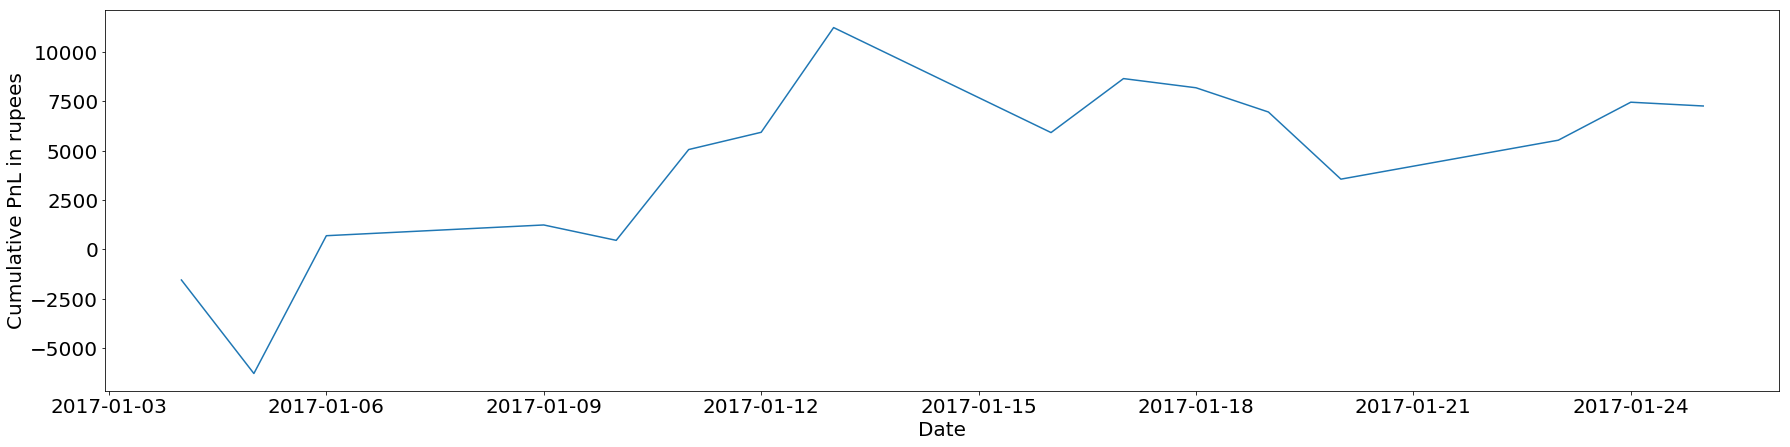

In [ ]:
#plotting the results
df=pd.DataFrame(dates,columns=["date"])
df["pnl"]=pnl
df.index=df.date
d=[]
p=[]
for i in df["date"].unique():
    s=df["pnl"].loc[i]
    d.append(i)
    p.append(s.sum())
plt.plot(d,np.array(p).cumsum())
plt.xlabel("Date")
plt.ylabel("Cumulative PnL in rupees")
#plt.rcParams["figure.figsize"] = (30,7)
#plt.rcParams.update({'font.size': 20})